## Import Library

In [1]:
import os
import time
import numpy as np
from tqdm import tqdm
from string import punctuation
from collections import Counter
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(123)

## Dataset Instructions

- You need to download the dataset from here: https://ai.stanford.edu/~amaas/data/sentiment/
- Then, you need to unzip the downloaded zipped file in the present working directory
- That should result in a new folder named aclImdb under the present working directory

## Load dataset

In [2]:
# read sentiments and reviews data from the text files
review_list = []
label_list = []
for label in ['pos', 'neg']:
    for fname in tqdm(os.listdir(f'./aclImdb/train/{label}/')):
        if 'txt' not in fname:
            continue
        with open(os.path.join(f'./aclImdb/train/{label}/', fname), encoding="utf8") as f:
            review_list += [f.read()]
            label_list += [label]
print ('Number of reviews :', len(review_list))

100%|██████████| 12500/12500 [00:04<00:00, 2929.59it/s]

Number of reviews : 25000


In [22]:
review_list[0]

'for a movie that gets no respect there sure are a lot of memorable quotes listed for this gem imagine a movie where joe piscopo is actually funny maureen stapleton is a scene stealer the moroni character is an absolute scream watch for alan the skipper hale jr as a police sgt'

## Preprocess the dataset

### get word counts

In [3]:
# pre-processing review text
review_list = [review.lower() for review in review_list]
review_list = [''.join([letter for letter in review if letter not in punctuation]) for review in tqdm(review_list)]

# accumulate all review texts together
reviews_blob = ' '.join(review_list)

# generate list of all words of all reviews
review_words = reviews_blob.split()

# get the word counts
count_words = Counter(review_words)

# sort words as per counts (decreasing order)
total_review_words = len(review_words)
sorted_review_words = count_words.most_common(total_review_words)

print(sorted_review_words[:10])

100%|██████████| 25000/25000 [00:01<00:00, 12899.05it/s]


[('the', 334691), ('and', 162228), ('a', 161940), ('of', 145326), ('to', 135042), ('is', 106855), ('in', 93028), ('it', 77099), ('i', 75719), ('this', 75190)]


### generate word tokens

In [4]:
# create word to integer (token) dictionary in order to encode text as numbers
vocab_to_token = {word:idx+1 for idx, (word, count) in enumerate(sorted_review_words)}
print(list(vocab_to_token.items())[:10])

[('the', 1), ('and', 2), ('a', 3), ('of', 4), ('to', 5), ('is', 6), ('in', 7), ('it', 8), ('i', 9), ('this', 10)]


### tokenize text data

In [5]:
reviews_tokenized = []
for review in review_list:
    word_to_token = [vocab_to_token[word] for word in review.split()]
    reviews_tokenized.append(word_to_token)
print(review_list[0])
print()
print (reviews_tokenized[0])

for a movie that gets no respect there sure are a lot of memorable quotes listed for this gem imagine a movie where joe piscopo is actually funny maureen stapleton is a scene stealer the moroni character is an absolute scream watch for alan the skipper hale jr as a police sgt

[15, 3, 17, 11, 201, 56, 1165, 47, 242, 23, 3, 168, 4, 891, 4325, 3513, 15, 10, 1514, 822, 3, 17, 112, 884, 14623, 6, 155, 161, 7307, 15816, 6, 3, 134, 20049, 1, 32064, 108, 6, 33, 1492, 1943, 103, 15, 1550, 1, 18993, 9055, 1809, 14, 3, 549, 6906]


In [23]:
review_list[0]

'for a movie that gets no respect there sure are a lot of memorable quotes listed for this gem imagine a movie where joe piscopo is actually funny maureen stapleton is a scene stealer the moroni character is an absolute scream watch for alan the skipper hale jr as a police sgt'

In [24]:
review_list[1]

'bizarre horror movie filled with famous faces but stolen by cristina raines later of tvs flamingo road as a pretty but somewhat unstable model with a gummy smile who is slated to pay for her attempted suicides by guarding the gateway to hell the scenes with raines modeling are very well captured the mood music is perfect deborah raffin is charming as cristinas pal but when raines moves into a creepy brooklyn heights brownstone inhabited by a blind priest on the top floor things really start cooking the neighbors including a fantastically wicked burgess meredith and kinky couple sylvia miles  beverly dangelo are a diabolical lot and eli wallach is great fun as a wily police detective the movie is nearly a crosspollination of rosemarys baby and the exorcistbut what a combination based on the bestseller by jeffrey konvitz the sentinel is entertainingly spooky full of shocks brought off well by director michael winner who mounts a thoughtfully downbeat ending with skill 12 from '

### tokenize output labels

In [6]:
# encode sentiments as 0 or 1
encoded_label_list = [1 if label =='pos' else 0 for label in label_list]

reviews_len = [len(review) for review in reviews_tokenized]

reviews_tokenized = [reviews_tokenized[i] for i, l in enumerate(reviews_len) if l>0 ]
encoded_label_list = np.array([encoded_label_list[i] for i, l in enumerate(reviews_len) if l> 0 ], dtype='float32')

### pad text sentences

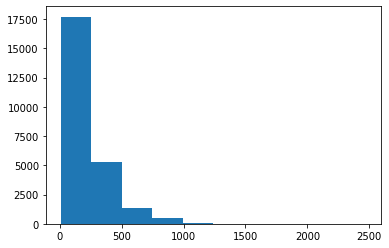

In [7]:
def pad_sequence(reviews_tokenized, sequence_length):
    ''' returns the tokenized review sequences padded with 0's or truncated to the sequence_length.
    '''
    padded_reviews = np.zeros((len(reviews_tokenized), sequence_length), dtype = int)
    
    for idx, review in enumerate(reviews_tokenized):
        review_len = len(review)
        
        if review_len <= sequence_length:
            zeroes = list(np.zeros(sequence_length-review_len))
            new_sequence = zeroes+review
        elif review_len > sequence_length:
            new_sequence = review[0:sequence_length]
        
        padded_reviews[idx,:] = np.array(new_sequence)
    
    return padded_reviews

sequence_length = 512
padded_reviews = pad_sequence(reviews_tokenized=reviews_tokenized, sequence_length=sequence_length)

plt.hist(reviews_len);

### split dataset to training and validation sets

In [8]:
train_val_split = 0.75
train_X = padded_reviews[:int(train_val_split*len(padded_reviews))]
train_y = encoded_label_list[:int(train_val_split*len(padded_reviews))]
validation_X = padded_reviews[int(train_val_split*len(padded_reviews)):]
validation_y = encoded_label_list[int(train_val_split*len(padded_reviews)):]

## Transform the dataset

In [9]:
train_dataset = TensorDataset(torch.from_numpy(train_X).to(device), torch.from_numpy(train_y).to(device))
validation_dataset = TensorDataset(torch.from_numpy(validation_X).to(device), torch.from_numpy(validation_y).to(device))


batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

## Visualise data samples

In [10]:
# get a batch of train data
train_data_iter = iter(train_dataloader)
X_example, y_example = train_data_iter.next()
print('Example Input size: ', X_example.size()) # batch_size, seq_length
print('Example Input:\n', X_example)
print()
print('Example Output size: ', y_example.size()) # batch_size
print('Example Output:\n', y_example)

Example Input size:  torch.Size([32, 512])
Example Input:
 tensor([[   0,    0,    0,  ...,  342,   23,  868],
        [   0,    0,    0,  ..., 6242,   12, 2872],
        [   0,    0,    0,  ...,   11,  105, 3490],
        ...,
        [   0,    0,    0,  ...,   42,    1,   17],
        [  48,   81,   22,  ..., 1141,   32,  105],
        [   0,    0,    0,  ...,  373,  150,  121]])

Example Output size:  torch.Size([32])
Example Output:
 tensor([0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
        1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1.])


## Define and instantiate the model

In [11]:
class RNN(nn.Module):
    def __init__(self, input_dimension, embedding_dimension, hidden_dimension, output_dimension):
        super().__init__()
        self.embedding_layer = nn.Embedding(input_dimension, embedding_dimension)  
        self.rnn_layer = nn.RNN(embedding_dimension, hidden_dimension, num_layers=1)
        self.fc_layer = nn.Linear(hidden_dimension, output_dimension)
        
    def forward(self, sequence):
        # sequence shape = (sequence_length, batch_size)
        embedding = self.embedding_layer(sequence)  
        # embedding shape = [sequence_length, batch_size, embedding_dimension]
        output, hidden_state = self.rnn_layer(embedding)
        # output shape = [sequence_length, batch_size, hidden_dimension]
        # hidden_state shape = [1, batch_size, hidden_dimension]
        final_output = self.fc_layer(hidden_state[-1,:,:].squeeze(0))      
        return final_output
    
input_dimension = len(vocab_to_token)+1 # +1 to account for padding
embedding_dimension = 100
hidden_dimension = 32
output_dimension = 1

rnn_model = RNN(input_dimension, embedding_dimension, hidden_dimension, output_dimension)

optim = torch.optim.Adam(rnn_model.parameters())
loss_func = nn.BCEWithLogitsLoss()

rnn_model = rnn_model.to(device)
loss_func = loss_func.to(device)

## Define the model training and validation routines

In [12]:
def accuracy_metric(predictions, ground_truth):
    """
    Returns 0-1 accuracy for the given set of predictions and ground truth
    """
    # round predictions to either 0 or 1
    rounded_predictions = torch.round(torch.sigmoid(predictions))
    success = (rounded_predictions == ground_truth).float() #convert into float for division 
    accuracy = success.sum() / len(success)
    return accuracy

In [13]:
def train(model, dataloader, optim, loss_func):
    loss = 0
    accuracy = 0
    model.train()
    
    for sequence, sentiment in dataloader:
        optim.zero_grad()     
        preds = model(sequence.T).squeeze()
        
        loss_curr = loss_func(preds, sentiment)
        accuracy_curr = accuracy_metric(preds, sentiment)
        
        loss_curr.backward()
        optim.step()
        
        loss += loss_curr.item()
        accuracy += accuracy_curr.item()
        
    return loss/len(dataloader), accuracy/len(dataloader)

In [14]:
def validate(model, dataloader, loss_func):
    loss = 0
    accuracy = 0
    model.eval()
    
    with torch.no_grad():
        for sequence, sentiment in dataloader:
            
            preds = model(sequence.T).squeeze()
            
            loss_curr = loss_func(preds, sentiment)   
            accuracy_curr = accuracy_metric(preds, sentiment)

            loss += loss_curr.item()
            accuracy += accuracy_curr.item()
        
    return loss/len(dataloader), accuracy/len(dataloader)

## Run the model training loop

In [15]:
num_epochs = 10
best_validation_loss = float('inf')

for ep in range(num_epochs):

    time_start = time.time()
    
    training_loss, train_accuracy = train(rnn_model, train_dataloader, optim, loss_func)
    validation_loss, validation_accuracy = validate(rnn_model, validation_dataloader, loss_func)
    
    time_end = time.time()
    time_delta = time_end - time_start  
    
    if validation_loss < best_validation_loss:
        best_validation_loss = validation_loss
        torch.save(rnn_model.state_dict(), 'rnn_model.pt')
    
    print(f'epoch number: {ep+1} | time elapsed: {time_delta}s')
    print(f'training loss: {training_loss:.3f} | training accuracy: {train_accuracy*100:.2f}%')
    print(f'validation loss: {validation_loss:.3f} |  validation accuracy: {validation_accuracy*100:.2f}%')
    print()

epoch number: 1 | time elapsed: 98.8182909488678s
training loss: 0.623 | training accuracy: 66.50%
validation loss: 0.867 |  validation accuracy: 42.10%

epoch number: 2 | time elapsed: 99.33515810966492s
training loss: 0.528 | training accuracy: 74.30%
validation loss: 0.777 |  validation accuracy: 56.33%

epoch number: 3 | time elapsed: 104.88390898704529s
training loss: 0.446 | training accuracy: 79.67%
validation loss: 0.854 |  validation accuracy: 55.93%

epoch number: 4 | time elapsed: 103.1292142868042s
training loss: 0.363 | training accuracy: 84.82%
validation loss: 0.925 |  validation accuracy: 56.73%

epoch number: 5 | time elapsed: 105.07887625694275s
training loss: 0.289 | training accuracy: 88.72%
validation loss: 1.444 |  validation accuracy: 41.83%

epoch number: 6 | time elapsed: 118.14540910720825s
training loss: 0.271 | training accuracy: 89.64%
validation loss: 0.895 |  validation accuracy: 58.15%

epoch number: 7 | time elapsed: 114.93999290466309s
training loss: 0

## Make predictions using trained model

In [16]:
def sentiment_inference(model, sentence):
    model.eval()
    
    # text transformations
    sentence = sentence.lower()
    sentence = ''.join([c for c in sentence if c not in punctuation])
    tokenized = [vocab_to_token.get(token, 0) for token in sentence.split()]
    tokenized = np.pad(tokenized, (512-len(tokenized), 0), 'constant')
    
    # model inference
    model_input = torch.LongTensor(tokenized).to(device)
    model_input = model_input.unsqueeze(1)
    pred = torch.sigmoid(model(model_input))
    
    return pred.item()

In [25]:
print(sentiment_inference(rnn_model, "This film is horrible"))

0.021870721131563187


In [18]:
print(sentiment_inference(rnn_model, "Director tried too hard but this film is bad"))

0.01491193100810051


In [19]:
print(sentiment_inference(rnn_model, "Decent movie, although could be shorter"))

0.18468593060970306


In [20]:
print(sentiment_inference(rnn_model, "This film will be houseful for weeks"))

0.3845883905887604


In [21]:
print(sentiment_inference(rnn_model, "I really loved the movie, every part of it, it was amazing"))

0.9387853741645813
